# 1. Load Data
------

In [1]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [2]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

100%|██████████| 1.54M/1.54M [00:00<00:00, 63.3MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/jonassouza872/vitoria-da-conquista-weather-data-september/versions/1
['temp.csv']


In [3]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [4]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Weather Conditions Gaussian Mixture Clustering

--------------------


The Gaussian Mixture Model (GMM) is a probability-based unsupervised learning algorithm that assumes data is generated by a combination of K multivariate Gaussian (normal) distributions, each representing a cluster with its own mean (centroid), covariance (shape and orientation), and mixture weight (proportion in the dataset). Unlike K-Means which rigidly assigns each point to a single cluster (hard clustering), GMM performs soft clustering by calculating membership probabilities of each observation to each Gaussian component through the Expectation-Maximization (EM) algorithm, allowing points at cluster boundaries to have multiple partial memberships, making it more flexible for data with ellipsoidal-shaped clusters, varying sizes, and overlaps. The selection of optimal number of components K uses statistical information criteria such as BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion) that penalize model complexity to avoid overfitting, where lower values indicate better fit, differing from K-Means' Elbow and Silhouette methods that evaluate inertia and cohesion/separation.

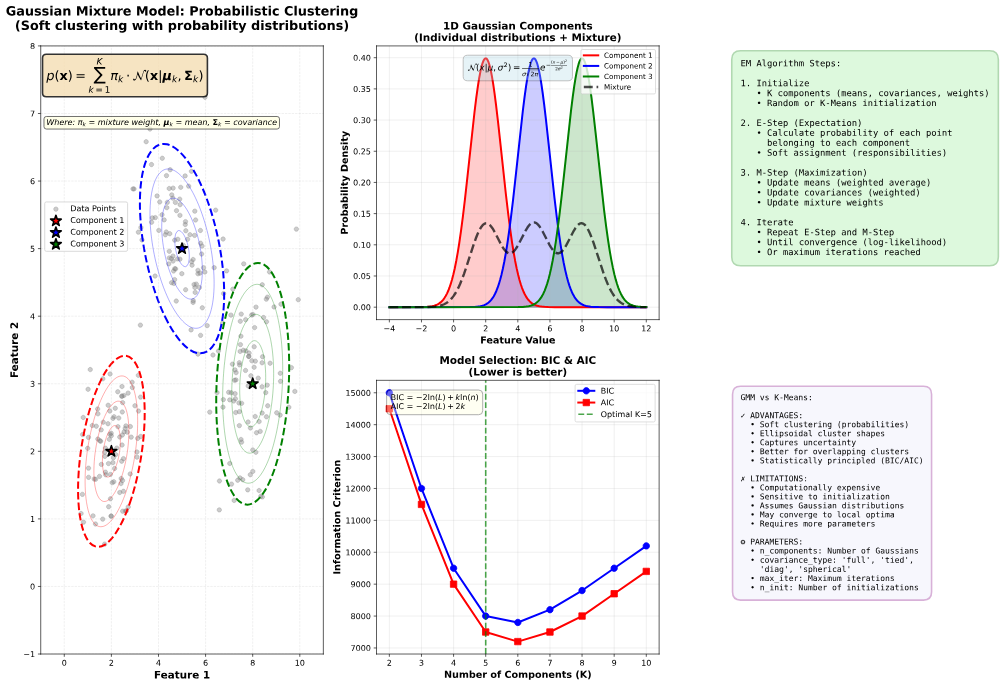

In [5]:
#Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture #Import GMM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [6]:
temp_columns = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
                'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C'] #all temperature sensors
humidity_columns = ['Umid_AHT20_pct', 'Umid_DHT11_pct'] # all humidity sensors
pressure_columns = ['Press_BMP280_hPa', 'Press_BMP180_hPa'] #all pressure sensors
#takes the average of all sensors to ensure that the measurement of all is relevant
df['Temp_Mean_C'] = df[temp_columns].mean(axis=1, skipna=True)
df['Humidity_Mean_pct'] = df[humidity_columns].mean(axis=1, skipna=True)
df['Pressure_Mean_hPa'] = df[pressure_columns].mean(axis=1, skipna=True)

In [7]:
features_cols = ['Temp_Mean_C', 'Humidity_Mean_pct', 'Pressure_Mean_hPa'] #feature columns that will be taken into consideration
#each feature is the average of a measurement variable
df_features = df[features_cols].dropna() #removes faulty data
print(f" Valid samples: {len(df_features):}")

 Valid samples: 82430


In [8]:
#normalizes the data for the model
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features) #normalization
#print to show data after normalization
print(f"\nMean after normalization: {features_scaled.mean(axis=0).round(4)}")
print(f"Standard deviation after normalization: {features_scaled.std(axis=0).round(4)}")


Mean after normalization: [-0. -0. -0.]
Standard deviation after normalization: [1. 1. 1.]


In [15]:
bic_scores = [] #list to store BIC scores (lower is better, penalizes model complexity)
aic_scores = [] #list to store AIC scores (lower is better, penalizes model complexity)
silhouette_scores = []

for k in range(2, 11): #tests for number of components from 2 to 11
    gmm_temp = GaussianMixture(n_components=k, random_state=42, n_init=10, covariance_type='full') #model
    gmm_temp.fit(features_scaled) #applies to normalized data
    bic_scores.append(gmm_temp.bic(features_scaled)) #adds BIC (Bayesian Information Criterion) to list - lower values indicate better fit with penalty for complexity
    aic_scores.append(gmm_temp.aic(features_scaled)) #adds AIC (Akaike Information Criterion) to list - lower values indicate better fit with penalty for complexity
    silhouette_scores.append(silhouette_score(features_scaled, gmm_temp.predict(features_scaled))) #adds silhouette score from training data - higher values indicate better cluster separation

- Model Evaluation Metrics

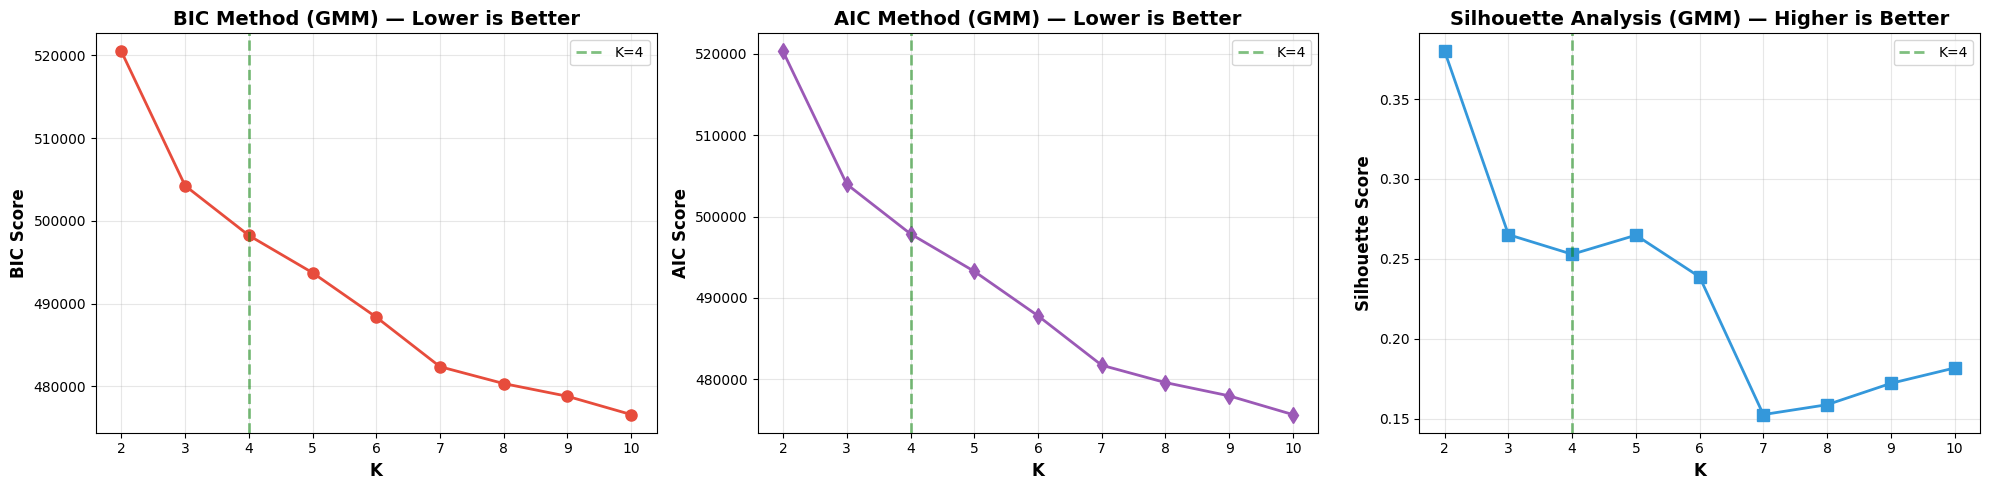

In [18]:
K_range = range(2, 11)  #range of the number of components from 2 to 11
fig, axes = plt.subplots(1, 3, figsize=(20, 5)) #size of subplots

# BIC method
axes[0].plot(K_range, bic_scores, marker='o', linewidth=2, markersize=8, color='#E74C3C')
axes[0].set_xlabel('K', fontsize=12, fontweight='bold')
axes[0].set_ylabel('BIC Score', fontsize=12, fontweight='bold')
axes[0].set_title('BIC Method (GMM) — Lower is Better', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=4, color='green', linestyle='--', linewidth=2, alpha=0.5, label='K=4')
axes[0].legend()

# AIC method
axes[1].plot(K_range, aic_scores, marker='d', linewidth=2, markersize=8, color='#9B59B6')
axes[1].set_xlabel('K', fontsize=12, fontweight='bold')
axes[1].set_ylabel('AIC Score', fontsize=12, fontweight='bold')
axes[1].set_title('AIC Method (GMM) — Lower is Better', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=4, color='green', linestyle='--', linewidth=2, alpha=0.5, label='K=4')
axes[1].legend()

# Silhouette
axes[2].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='#3498DB')
axes[2].set_xlabel('K', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[2].set_title('Silhouette Analysis (GMM) — Higher is Better', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axvline(x=4, color='green', linestyle='--', linewidth=2, alpha=0.5, label='K=4')
axes[2].legend()

plt.tight_layout()
plt.show()

- The optimal number of components was determined to be K=4, balancing statistical criteria (BIC/AIC showing diminishing returns beyond K=4), cluster quality metrics (Silhouette Score of 0.25 indicating reasonable separation), and meteorological interpretability of the resulting weather patterns.

In [ ]:
n_components = 4 #number of components to be fitted
gmm = GaussianMixture(n_components=n_components, random_state=42, n_init=10, max_iter=300, covariance_type='full') #applies GMM considering number of Gaussian components, reproducibility, initializations and iterations
clusters = gmm.fit_predict(features_scaled) #model training to predict values based on normalized data

df.loc[df_features.index, 'cluster'] = clusters #saves the clusters assigned by the model
cluster_counts = df['cluster'].value_counts().sort_index() #orders the clusters from largest to smallest in number of points
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df_features)) * 100 #shows how many % the cluster represents of the total
    print(f"  Cluster {cluster_id}: {count:,} samples ({percentage:.1f}%)")